<a href="https://colab.research.google.com/github/felix0097/CVAE_mnist/blob/master/cvae_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.1.0
!pip install tensorflow-probability==0.9.0

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from math import ceil

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**Define Convolutional CVAE model**

In [0]:
class ConvCVAE(tf.keras.Model):

  def __init__(self, 
               input_shape_img: Tuple[int, int, int],
               input_shape_cond: int, 
               latent_dim: int):

    super(ConvCVAE, self).__init__()

    self.input_shape_img = input_shape_img
    self.latent_dim = latent_dim

    self.conv_enc = tf.keras.Sequential(
        [tf.keras.layers.InputLayer(input_shape=input_shape_img),
         tf.keras.layers.Conv2D(filters=64, 
                                kernel_size=3, 
                                activation='relu',
                                padding='same'),
         tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
                                      padding='same'),
         tf.keras.layers.Conv2D(filters=128, 
                                kernel_size=3,
                                activation='relu',
                                padding='same'),
         tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
                                      padding='same'),
         tf.keras.layers.Flatten()
      ],
      name='encoder')
    
    self.enc = tf.keras.Sequential(
        [tf.keras.layers.InputLayer(
            input_shape=self.conv_enc.output_shape[1] + input_shape_cond
            ),
         tf.keras.layers.Dense(self.conv_enc.output_shape[1] // 4,
                               activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(
                                   l=1e-4)
                               ),
         tf.keras.layers.Dense(2*latent_dim,
                               kernel_regularizer=tf.keras.regularizers.l2(
                                   l=1e-4)
                               )
         ]
    )

    self.dec = tf.keras.Sequential(
        [tf.keras.layers.InputLayer(
            input_shape=(latent_dim + input_shape_cond)
            ),
         tf.keras.layers.Dense(units=self.conv_enc.output_shape[1],
                               activation=tf.nn.relu,
                               kernel_regularizer=tf.keras.regularizers.l2(
                                   l=1e-4)
                               ),
         tf.keras.layers.Reshape(
             target_shape=self.conv_enc.layers[-2].output_shape[1:]
             ),
         tf.keras.layers.Conv2DTranspose(filters=128,
                                         kernel_size=3,
                                         activation='relu',
                                         padding='same'
                                         ),
         tf.keras.layers.UpSampling2D(size=(2, 2)),
         tf.keras.layers.Conv2DTranspose(filters=64,
                                         kernel_size=3,
                                         activation='relu',
                                         padding='same'
                                         ),
         tf.keras.layers.UpSampling2D(size=(2, 2)),
         tf.keras.layers.Conv2DTranspose(filters=input_shape_img[2], 
                                         kernel_size=3, 
                                         strides=(1, 1),
                                         padding='same'
                                         ),
         tf.keras.layers.Activation('sigmoid')
        ],
        name='decoder')
    
  def call(self, inputs, training=False):

    img_input = inputs[0]
    cond_input = inputs[1]

    encoded_img = self.conv_enc(img_input)
    enc_output = self.enc(tf.concat([encoded_img, cond_input], axis=1))
    mean, log_scale = tf.split(enc_output, num_or_size_splits=2, axis=1)
    scale= tf.math.exp(log_scale)

    latent_dist = tfp.distributions.MultivariateNormalDiag(loc=mean,
                                                           scale_diag=scale)
      
    ref_dist = tfp.distributions.MultivariateNormalDiag(
        loc=tf.zeros([self.latent_dim])
        )

    kl_divergence = tfp.distributions.kl_divergence(latent_dist, ref_dist)

    self.add_loss(tf.math.reduce_mean(kl_divergence, 
                                      name='KL_divergence_loss'),
                  inputs=True
    )

    input_dec = tf.concat([latent_dist.sample(), cond_input], axis=1)
    dec_img = self.dec(input_dec)
    dec_img = tf.image.resize_with_crop_or_pad(dec_img, 
                                               self.input_shape_img[0],
                                               self.input_shape_img[1])
      
    return dec_img
      

**Prepare data set for fitting**

In [0]:
BATCH_SIZE = 1024

def preprocess_data(elem):
    img = elem['image']
    label = elem['label']
    # convert input image to [0, 1]
    img = tf.cast(img, dtype=tf.float32) / tf.cast(255., dtype=tf.float32)
    # binarize image
    img = tf.cast(img >= 0.25, dtype=tf.float32)
    img_input = img - 0.5
    # one hot encode label
    label = tf.one_hot(tf.cast(label, dtype=tf.uint8), depth=10)

    return ((img_input, label), img)


ds_train = tfds.load(name="mnist", split="train")
ds_val = tfds.load(name="mnist", split="test")

ds_train = ds_train.map(preprocess_data, 
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(preprocess_data, 
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_train = ds_train.shuffle(5000, reshuffle_each_iteration=True)\
                   .repeat()\
                   .batch(BATCH_SIZE)\
                   .prefetch(10)
ds_val = ds_val.shuffle(5000, reshuffle_each_iteration=True)\
               .repeat()\
               .batch(BATCH_SIZE)\
               .prefetch(10)


**Fit model**

In [0]:
# remove logs data
# !kill 7030
# !rm -r logs

%load_ext tensorboard
%tensorboard --logdir=logs

In [9]:
conv_cvae = ConvCVAE(input_shape_img=(28, 28, 1),
                     input_shape_cond=10,
                     latent_dim=50)

conv_cvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy())

hist = conv_cvae.fit(ds_train,
                     validation_data=ds_val,
                     epochs=50,
                     steps_per_epoch=ceil(60000 / BATCH_SIZE),
                     validation_steps=ceil(10000 / BATCH_SIZE),
                     callbacks=[
                                tf.keras.callbacks.EarlyStopping(
                                    patience=5, 
                                    restore_best_weights=True
                                ),
                                tf.keras.callbacks.ReduceLROnPlateau(),
                                tf.keras.callbacks.TensorBoard()
                               ]
                     )


Train for 59 steps, validate for 10 steps
Epoch 1/50
 1/59 [..............................] - ETA: 2:47 - loss: 1.3545WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.305584). Check your callbacks.


59/59 [==============================] - 26s 435ms/step - loss: 0.8209 - val_loss: 0.4446
Epoch 2/50
59/59 [==============================] - 22s 366ms/step - loss: 0.4095 - val_loss: 0.3811
Epoch 3/50
59/59 [==============================] - 36s 616ms/step - loss: 0.3694 - val_loss: 0.3550
Epoch 4/50
59/59 [==============================] - 36s 611ms/step - loss: 0.3482 - val_loss: 0.3373
Epoch 5/50
59/59 [==============================] - 31s 524ms/step - loss: 0.3331 - val_loss: 0.3245
Epoch 6/50
59/59 [==============================] - 33s 558ms/step - loss: 0.3214 - val_loss: 0.3137
Epoch 7/50
59/59 [==============================] - 35s 585ms/step - loss: 0.3122 - val_loss: 0.3056
Epoch 8/50
59/59 [==============================] - 33s 563ms/step - loss: 0.3043 - val_loss: 0.2982
Epoch 9/50
59/59 [==============================] - 35s 586ms/step - loss: 0.2978 - val_loss: 0.2923
Epoch 10/50
59/59 [==============================] - 27s 452ms/step - loss: 0.2923 - val_loss: 0.2871


**See how generated images look like**

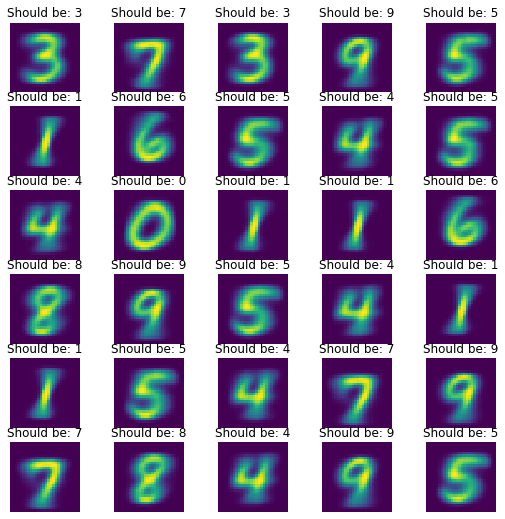

In [10]:
NUM_IMGS = 30
LATENT_DIM = 50

noise = np.random.normal(size=(NUM_IMGS, LATENT_DIM))
cond_input = np.zeros(shape=(NUM_IMGS, 10))

x_idx = np.arange(0, NUM_IMGS)
y_idx = np.random.randint(low=0, high=10, size=(NUM_IMGS))
cond_input[x_idx, y_idx] = 1.

dec_input = np.concatenate([noise, cond_input], axis=1).astype(np.float32)
imgs = conv_cvae.dec(dec_input).numpy()

fig, axs = plt.subplots(nrows=NUM_IMGS//5, ncols=5, figsize=(9, 9))

for img_idx in range(imgs.shape[0]):
  img = np.sum(imgs[img_idx, :, :, :], axis=-1)
  axs[np.unravel_index(img_idx, (NUM_IMGS//5, 5))].imshow(img)
  axs[np.unravel_index(img_idx, (NUM_IMGS//5, 5))].axis('off')
  axs[np.unravel_index(img_idx, (NUM_IMGS//5, 5))].set_title(
      f'Should be: {int(np.argwhere(cond_input[img_idx, :] == 1))}'
      )

plt.show()

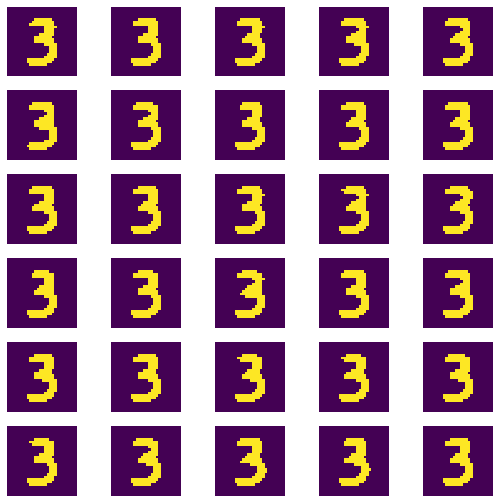

In [64]:
noise = np.random.normal(size=(NUM_IMGS, LATENT_DIM), scale=1)
cond_input = np.zeros(shape=(NUM_IMGS, 10))

cond_input[:, 3]  = 1.

dec_input = np.concatenate([noise, cond_input], axis=1).astype(np.float32)
imgs = conv_cvae.dec(dec_input).numpy()

fig, axs = plt.subplots(nrows=NUM_IMGS//5, ncols=5, figsize=(9, 9))

for img_idx in range(imgs.shape[0]):
  img = np.sum(imgs[img_idx, :, :, :], axis=-1) > 0.5
  axs[np.unravel_index(img_idx, (NUM_IMGS//5, 5))].imshow(img)
  axs[np.unravel_index(img_idx, (NUM_IMGS//5, 5))].axis('off')

plt.show()